<a href="https://colab.research.google.com/github/mjdall/pinterest_scraper/blob/master/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
"""
efficient net paper - https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html
efficient net fine tuning - https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
efficient net implementation - https://github.com/qubvel/efficientnet
transfer learning example - https://www.tensorflow.org/tutorials/images/transfer_learning
classification head - https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
image embeddings - https://rom1504.medium.com/image-embeddings-ed1b194d113e
  https://github.com/rom1504/image_embeddings/blob/master/notebooks/using_the_lib.ipynb
  https://github.com/rom1504/image_embeddings/blob/master/notebooks/from_scratch.ipynb

"""

'\nefficient net paper - https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html\nefficient net fine tuning - https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/\nefficient net implementation - https://github.com/qubvel/efficientnet\ntransfer learning example - https://www.tensorflow.org/tutorials/images/transfer_learning\nclassification head - https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/\nimage embeddings - https://rom1504.medium.com/image-embeddings-ed1b194d113e\n  https://github.com/rom1504/image_embeddings/blob/master/notebooks/using_the_lib.ipynb\n  https://github.com/rom1504/image_embeddings/blob/master/notebooks/from_scratch.ipynb\n\n'

In [3]:
!pip install umap-learn

     |████████████████████████████████| 81kB 5.2MB/s 
     |████████████████████████████████| 1.2MB 15.4MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=c80a85b1ab1a47982ee95fc184112ceaca07953acf9f2077798ec6d769fc147c
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51362 sha256=ccccd529ae3d15b2f5d1b0eba742ae56ed4783abbbb2eac9f1f94b51b7e8c1f9
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import os

os.chdir("/content/drive/MyDrive/pinterest_scraper/")

In [6]:
import pandas as pd

image_locs = pd.read_csv("data/image_reference.csv")
image_locs.sample(5)

Unnamed: 0  ... group_id
352          352  ...      145
2655        2655  ...      448
5234        5234  ...       35
62            62  ...       62
2721        2721  ...       14

[5 rows x 4 columns]

In [7]:
def get_group(group_id, training_ids, testing_ids):
  if group_id in training_ids:
    return("training")
  elif group_id in testing_ids:
    return("testing")
  else:
    return("validation")

In [8]:
import math
import numpy as np

TRAINING_SIZE = .7

available_labels = image_locs.label.unique().tolist()

for label in available_labels:
  label_subset = image_locs[image_locs.label == label]
  group_ids = label_subset.group_id.reset_index(drop=True)

  # get train/test/validation ids
  training_ids = group_ids.sample(frac=TRAINING_SIZE)
  remaining_ids = group_ids[~group_ids.isin(training_ids)]
  testing_ids = remaining_ids.sample(frac=.5)

  # make a lambda to apply
  alloc_lmbda = lambda gid: get_group(gid, training_ids, testing_ids)

  # write the split allocation to the df
  image_locs.loc[label_subset.index, "split"] = label_subset.group_id.apply(alloc_lmbda)

image_locs

Unnamed: 0            label  ... group_id       split
0              0  90s fashion men  ...        0    training
1              1  90s fashion men  ...        1  validation
2              2  90s fashion men  ...        2    training
3              3  90s fashion men  ...        3    training
4              4  90s fashion men  ...        4    training
...          ...              ...  ...      ...         ...
5694        5694  White aesthetic  ...      495     testing
5695        5695  White aesthetic  ...      496    training
5696        5696  White aesthetic  ...      497     testing
5697        5697  White aesthetic  ...      498     testing
5698        5698  White aesthetic  ...      499    training

[5699 rows x 5 columns]

In [9]:
image_locs.groupby("label").split.value_counts()

label                      split     
90s fashion men            training      145
                           testing        31
                           validation     31
Bullet journal             training      350
                           testing        75
                           validation     75
Easy drawings              training      350
                           testing        75
                           validation     75
Food porn                  training      350
                           testing        75
                           validation     75
Forearm tattoos            training      350
                           testing        75
                           validation     75
Interior design            training      350
                           testing        75
                           validation     75
Mens clothing styles       training      350
                           testing        75
                           validation     75
Modern farmhouse 

In [10]:
import pathlib
import shutil
import re

def get_save_directory_name(label):
  return(re.sub(r"\s+", "_" , label.lower()))

get_file_directory = lambda file_location: str(pathlib.Path(file_location).parent) + "/"

def partition_data(image_locations):
  # get the label directory name
  image_locations["label_dir"] = image_locations.label.apply(
      get_save_directory_name)
  image_locations["filename"] = image_locations.file_location.apply(
      os.path.basename)
  label_dirs = image_locations.label_dir.unique()

  # remove current allocation of images and re-create the data directories
  data_splits = image_locations.split.unique().tolist()
  for split in data_splits:
    split_dir = f"data/{split}"
    if os.path.exists(split_dir):
      shutil.rmtree(split_dir)
    for label_dir in label_dirs:
      os.makedirs(f"{split_dir}/{label_dir}", exist_ok=True)


  # get the new path of the image
  image_locations["new_location"] = ("data/"
    + image_locations.split
    + "/"
    + image_locations.label_dir
    + "/"
    + image_locations.filename)

  # copy the image into the new directory
  for _, image_row in image_locations.iterrows():
    # todo: add progress bar here
    shutil.copy2(image_row.file_location, image_row.new_location)

# partition_data(image_locs)
# image_locs.to_csv("data/image_partitions.csv")

In [11]:
IMG_SIZE = 224
SIZE = (IMG_SIZE, IMG_SIZE)
BATCH_SIZE = 64
DATASET_NAME = "pinterest"
NUM_CLASSES = image_locs.label.nunique()

In [12]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# load in the datasets
train_ds = image_dataset_from_directory("data/training", label_mode="categorical")
test_ds = image_dataset_from_directory("data/testing", label_mode="categorical")
validation_ds = image_dataset_from_directory("data/validation", label_mode="categorical")

train_ds

Found 3989 files belonging to 12 classes.
Found 855 files belonging to 12 classes.
Found 855 files belonging to 12 classes.


<BatchDataset shapes: ((None, 256, 256, 3), (None, 12)), types: (tf.float32, tf.float32)>

In [13]:
import tensorflow as tf
resize_lambda = lambda image, label: (tf.image.resize(image, SIZE), label)

def preprocess_dataset(dataset, batch_size=BATCH_SIZE):
  dataset = dataset.map(resize_lambda)
  # dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  return(dataset)

train_ds = preprocess_dataset(train_ds)
test_ds = preprocess_dataset(test_ds)
validation_ds = preprocess_dataset(validation_ds)

In [14]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [15]:
# import matplotlib.pyplot as plt

# for image, _ in train_ds.take(1):
#   plt.figure(figsize=(10, 10))

#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)

#     augmented_image = img_augmentation(first_image)
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')

In [16]:
from tensorflow.keras.applications import EfficientNetB0

IMG_SHAPE = SIZE + (3,)

base_model = tf.keras.applications.EfficientNetB0(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights="imagenet")
base_model.trainable = False

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

print(feature_batch.shape)

16711680/16705208 [==============================] - 0s 0us/step
(32, 7, 7, 1280)


In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

(32, 1280)


In [18]:
prediction_layer = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)

print(prediction_batch.shape)

(32, 12)


In [19]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

In [20]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = img_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=["accuracy"])

len(model.trainable_variables)

2

In [22]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_ds)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

27/27 [==============================] - 166s 4s/step - loss: 2.7429 - accuracy: 0.0702
initial loss: 2.74
initial accuracy: 0.07


In [23]:
history = model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=validation_ds)

Epoch 1/10
125/125 [==============================] - 715s 6s/step - loss: 2.3562 - accuracy: 0.2038 - val_loss: 2.0023 - val_accuracy: 0.3731
Epoch 2/10
125/125 [==============================] - 242s 2s/step - loss: 1.7823 - accuracy: 0.4793 - val_loss: 1.5571 - val_accuracy: 0.5883
Epoch 3/10
125/125 [==============================] - 243s 2s/step - loss: 1.4541 - accuracy: 0.5979 - val_loss: 1.2896 - val_accuracy: 0.6550
Epoch 4/10
125/125 [==============================] - 243s 2s/step - loss: 1.2368 - accuracy: 0.6598 - val_loss: 1.1238 - val_accuracy: 0.6936
Epoch 5/10
125/125 [==============================] - 242s 2s/step - loss: 1.1128 - accuracy: 0.6754 - val_loss: 1.0157 - val_accuracy: 0.7053
Epoch 6/10
125/125 [==============================] - 245s 2s/step - loss: 1.0184 - accuracy: 0.7017 - val_loss: 0.9409 - val_accuracy: 0.7158
Epoch 7/10
125/125 [==============================] - 245s 2s/step - loss: 0.9421 - accuracy: 0.7145 - val_loss: 0.8854 - val_accuracy: 0.7322

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



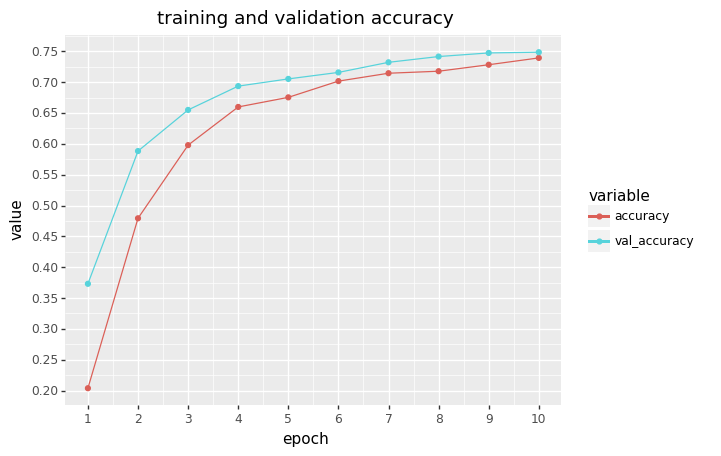

<ggplot: (8753758292141)>

In [24]:
from plotnine import ggplot, aes, geom_line, geom_point, ggtitle, scale_x_continuous, scale_y_continuous

history_df = pd.DataFrame(history.history)
history_df["epoch"] = range(1, len(history_df.accuracy) + 1)
history_melt = history_df.melt(value_vars=["accuracy", "val_accuracy", "loss", "val_loss"], id_vars = "epoch")

accuracy_stats = history_melt[history_melt.variable.isin(["accuracy", "val_accuracy"])]
loss_stats = history_melt[history_melt.variable.isin(["loss", "val_loss"])]

(
  ggplot(accuracy_stats, aes(x = "epoch", y = "value", colour = "variable")) +
  geom_line() +
  geom_point() +
  scale_x_continuous(breaks = range(12)) +
  scale_y_continuous(breaks = np.linspace(0.0, 1.0, 21)) +
  ggtitle("training and validation accuracy")
)


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



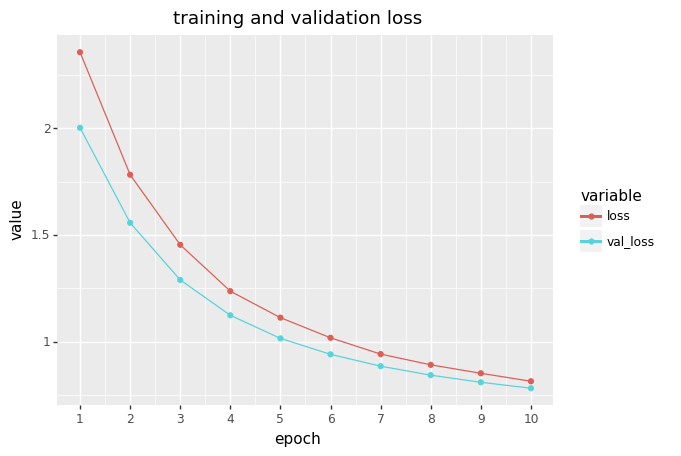

<ggplot: (8753781955425)>

In [25]:
(
  ggplot(loss_stats, aes(x = "epoch", y = "value", colour = "variable")) +
  geom_line() +
  geom_point() +
  scale_x_continuous(breaks = range(12)) +
  ggtitle("training and validation loss")
)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



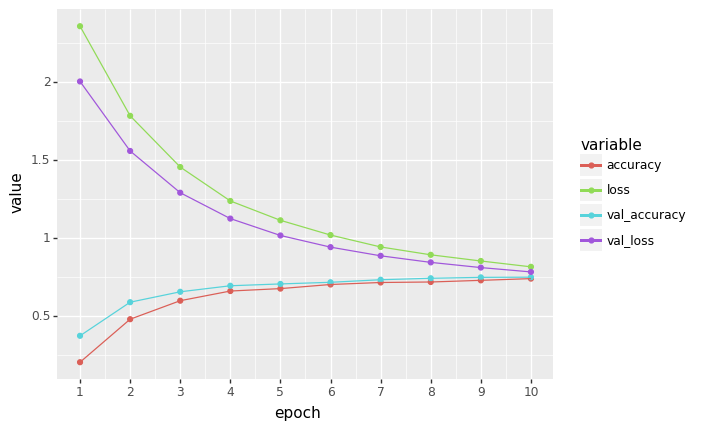

<ggplot: (8753757657233)>

In [26]:
(
  ggplot(history_melt, aes(x = "epoch", y = "value", colour = "variable")) +
  geom_point() +
  scale_x_continuous(breaks = range(12)) +
  geom_line()
)

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 12)                15372     
Total params: 4,064,943
Trainable params: 15,372
Non-trainable params: 4,049,571
______________________________________________

In [28]:
from keras.models import Model

emb_model = Sequential(model.layers[:-2])

emb_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
Total params: 4,049,571
Trainable params: 0
Non-trainable params: 4,049,571
_________________________________________________________________


In [29]:
def images_to_embeddings(model, dataset):
  return model.predict(dataset.flat_map(lambda image_raw, image_name: image_raw), verbose=1)

In [30]:
test_images = [(x, y) for x, y in test_ds]
all_labels = np.concatenate([y for _, y in test_images], axis=0)
all_labels = [str(int(tf.argmax(label))) for label in all_labels]

image_embeddings = []
for (image_batch, _) in test_images:
  image_embeddings.append(emb_model.predict(image_batch))

image_embeddings = np.concatenate(image_embeddings, axis=0)
image_embeddings[0]

array([-0.13348246, -0.06158477, -0.17187703, ..., -0.10444469,
       -0.14880668,  0.11480224], dtype=float32)

In [31]:
label_lookup = { str(i): name for i, name in enumerate(os.listdir("data/testing"))}
image_labels = [label_lookup[label] for label in all_labels]

image_labels[:10]

['starbucks_drinks',
 'modern_farmhouse_kitchens',
 'forearm_tattoos',
 'bullet_journal',
 'simple_doodles',
 'white_aesthetic',
 'mens_clothing_styles',
 'white_aesthetic',
 'white_aesthetic',
 'forearm_tattoos',
 'modern_farmhouse_kitchens',
 'bullet_journal',
 'mens_clothing_styles',
 'forearm_tattoos',
 'bullet_journal',
 'white_aesthetic',
 '90s_fashion_men',
 'tattoo_sketches',
 'starbucks_drinks',
 '90s_fashion_men',
 'bullet_journal',
 'interior_design',
 'food_porn',
 'mens_clothing_styles',
 'forearm_tattoos',
 'easy_drawings',
 'interior_design',
 'white_aesthetic',
 'bullet_journal',
 'interior_design',
 'modern_farmhouse_kitchens',
 'white_aesthetic',
 'white_aesthetic',
 'tattoo_sketches',
 'food_porn',
 'white_aesthetic',
 'bullet_journal',
 'starbucks_drinks',
 'white_aesthetic',
 'starbucks_drinks',
 'simple_doodles',
 'simple_doodles',
 'forearm_tattoos',
 'simple_doodles',
 'bullet_journal',
 'bullet_journal',
 'bullet_journal',
 'food_porn',
 'forearm_tattoos',
 'mo

### Notes

* Embeddings are wrong, need to fix (or labels are, need to debug)

In [35]:
!pip install pacmap

     |████████████████████████████████| 655kB 7.0MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391648 sha256=0a5feffc5a13f6d030d8bf2fff2570e1bb6a65b66a10089a250723e735798e1a
  Stored in directory: /root/.cache/pip/wheels/3a/c5/59/cce7e67b52c8e987389e53f917b6bb2a9d904a03246fadcb1e
Successfully built annoy


In [58]:
import pacmap
import umap


def run_umap(embeddings, labels):
    """
    Runs umap on an array of vectors
        and returns a dataframe with the embeddings and class labels.
    """
    umap_model = umap.UMAP(n_components=3)
    umap_comps = umap_model.fit_transform(embeddings)

    return(
        pd.DataFrame({
            "component_1": umap_comps[:, 0],
            "component_2": umap_comps[:, 1],
            "component_3": umap_comps[:, 2],
            "class": labels,
            "row_id": range(len(pacmap_comps)),
        })
    )


def run_pacmap(embeddings, labels,**pacmap_kwargs):
    """
    Runs pacmap algorithm on a vector of embeddings.
    Returns a pandas dataframe with labelled components.
    """
    # get pacmap model
    pacmap_model = pacmap.PaCMAP(
        n_dims=3,
        n_neighbors=None,
        MN_ratio=0.5,
        FP_ratio=2.0)
    if pacmap_kwargs:
        pacmap_model = pacmap.PaCMAP(n_dims=3, **pacmap_kwargs) 

    # create components
    pacmap_comps = pacmap_model.fit_transform(embeddings, init="pca")

    # return labelled components
    return(
        pd.DataFrame({
            "component_1": pacmap_comps[:, 0],
            "component_2": pacmap_comps[:, 1],
            "component_3": pacmap_comps[:, 2],
            "class": labels,
            "row_id": range(len(pacmap_comps)),
        })
    )


def vis_components(
    components_df,
    xcol="component_1",
    ycol="component_2",
    zcol="component_3",
    colour_col="class",
    height=780,
    width=1366):
    """
    Plots a component dataframe in an interactive 3d plotly plot.
    Returns the plotly figure.
    """
    fig = px.scatter_3d(
        components_df,
        x=xcol,
        y=ycol,
        z=zcol,
        color=colour_col,
        hover_name="row_id")

    fig.update_traces(
        marker=dict(size=3),
        selector=dict(mode="markers"))

    fig.update_layout(
        margin=dict(l=20, r=20, t=20, b=20),
        height=height, width=width
    )

    return(fig)


In [59]:
umap_components = run_pacmap(image_embeddings, image_labels)

vis_components(umap_components)

In [60]:
pacmap_components = run_pacmap(image_embeddings, image_labels)

vis_components(pacmap_components)


### Visualising Outliers
* 58 - 90s fashion men, sits with interior design

In [86]:
!pip install sentence-transformers

     |████████████████████████████████| 81kB 5.2MB/s 
     |████████████████████████████████| 2.3MB 18.9MB/s 
     |████████████████████████████████| 1.2MB 34.9MB/s 
     |████████████████████████████████| 3.3MB 34.2MB/s 
     |████████████████████████████████| 901kB 32.9MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.2.0-cp37-none-any.whl size=123339 sha256=56807bee9b1ea1c4d97f70c46fb618b28e7f1e96a0fa2372d4e0e2f48158e5c9
  Stored in directory: /root/.cache/pip/wheels/0f/06/f7/faaa96fdda87462b4fd5c47b343340e9d5531ef70d0eef8242
Successfully built sentence-transformers


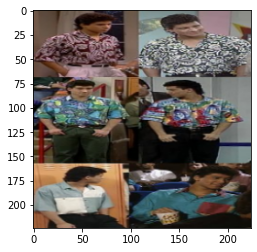

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline

test_images_flat = np.concatenate([x for x, _ in test_images], axis=0)

plot_image = lambda img: plt.imshow(img.astype(np.int32))

plot_image(test_images_flat[58])

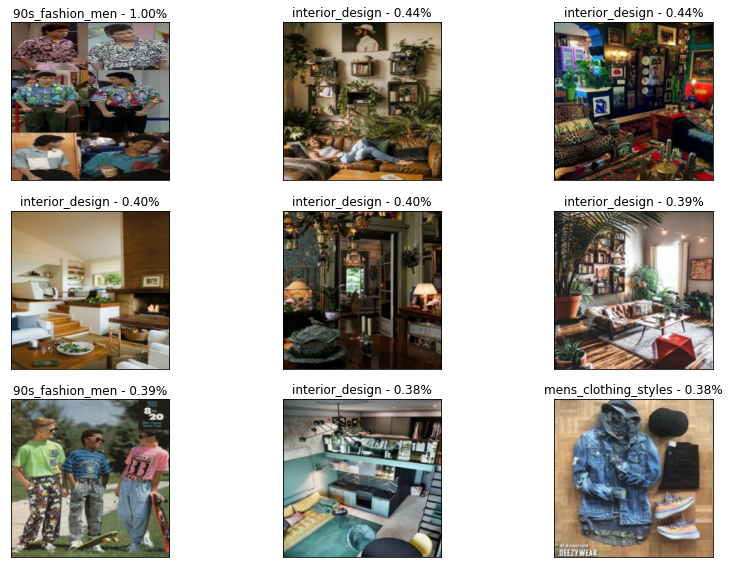

In [126]:
def visualise_nearest_neighbours(row_id):
  base_image = image_embeddings[row_id]
  image_hits = util.semantic_search(base_image, image_embeddings)[0]

  fig, ax = plt.subplots(nrows=3, ncols=3, figsize=[12, 8])

  for i, axi in enumerate(ax.flat):
    img_index = image_hits[i]["corpus_id"]
    sim_score = f"%.2f" % image_hits[i]["score"]
    img = test_images_flat[img_index].astype(np.int32)

    axi.imshow(img)
    x_axis = axi.get_xaxis()
    x_axis.set_visible(False)

    y_axis = axi.get_yaxis()
    y_axis.set_visible(False)

    rowid = i // 3
    colid = i % 3

    axi.set_title(f"{image_labels[img_index]} - {sim_score}%")
  
  return(fig.tight_layout())

visualise_nearest_neighbours(58)

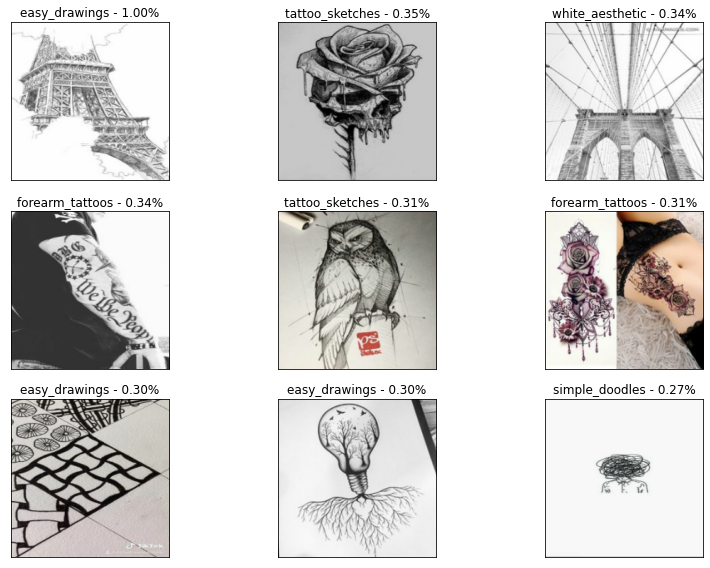

In [127]:
# more reliant on colour rather than anything in the image
visualise_nearest_neighbours(407)

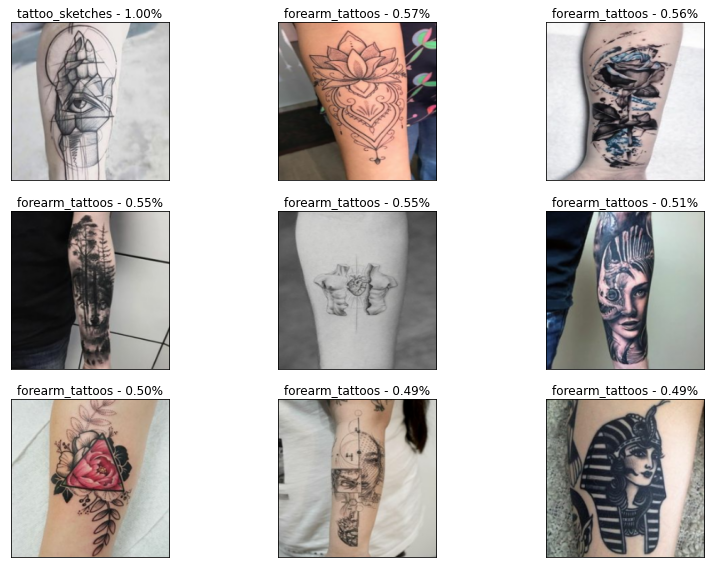

In [128]:
# is a tattoo and not a sketch
visualise_nearest_neighbours(224)

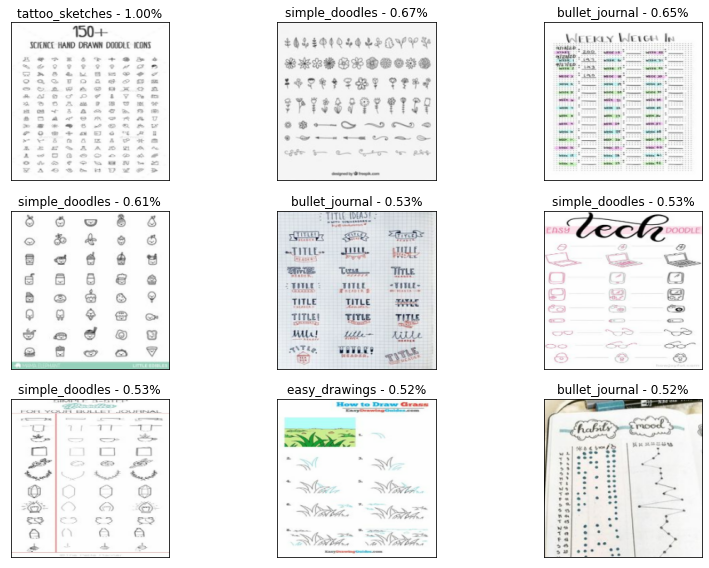

In [129]:
visualise_nearest_neighbours(500)

In [131]:
visualise_nearest_neighbours(143)

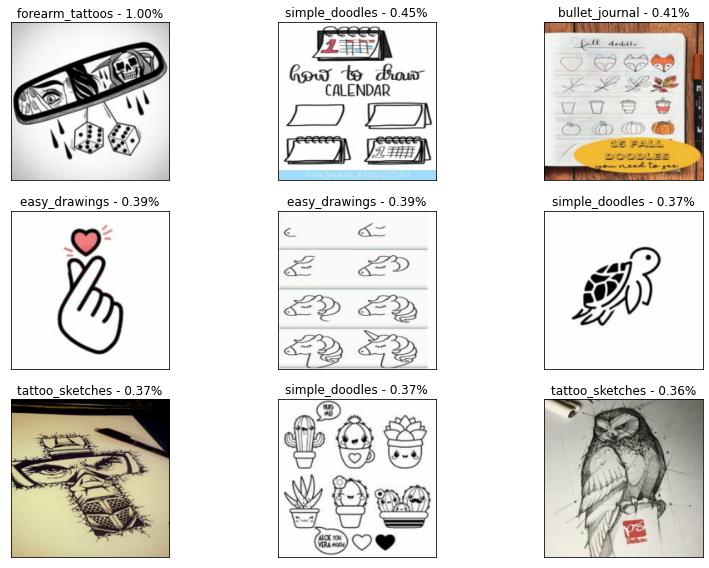

In [133]:
visualise_nearest_neighbours(178)

In [134]:
visualise_nearest_neighbours(632)

In [135]:
visualise_nearest_neighbours(673)

### Regular images:

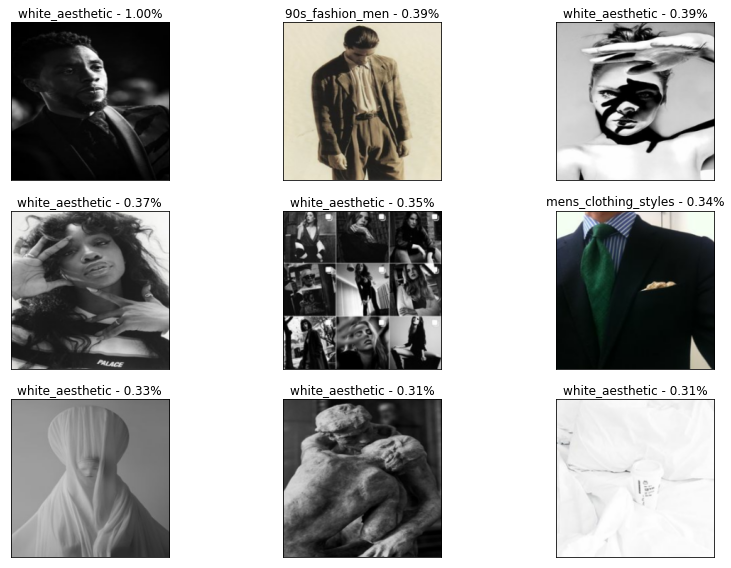

In [136]:
visualise_nearest_neighbours(279)

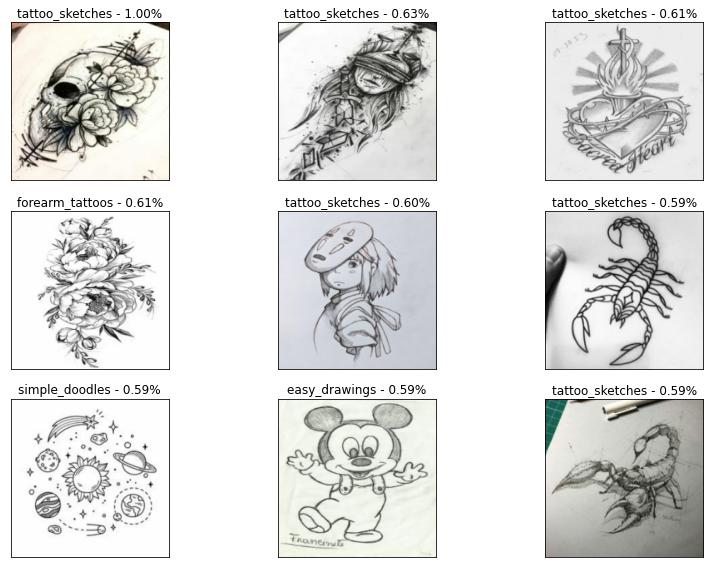

In [137]:
visualise_nearest_neighbours(105)

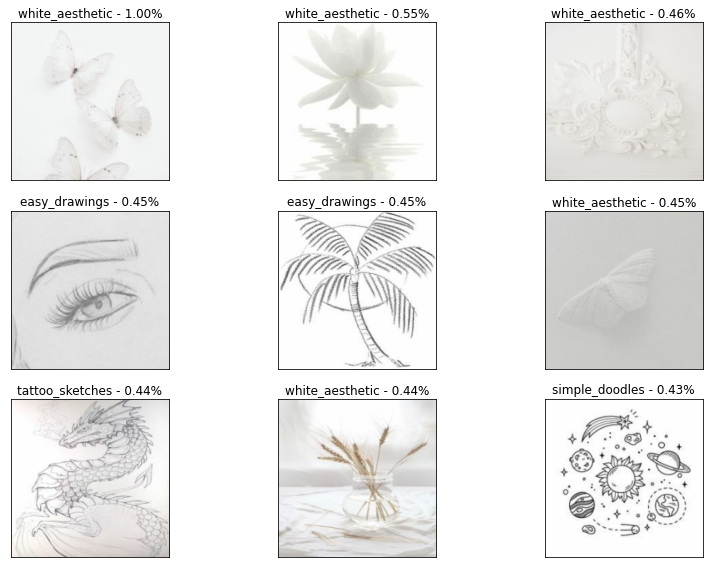

In [138]:
visualise_nearest_neighbours(15)

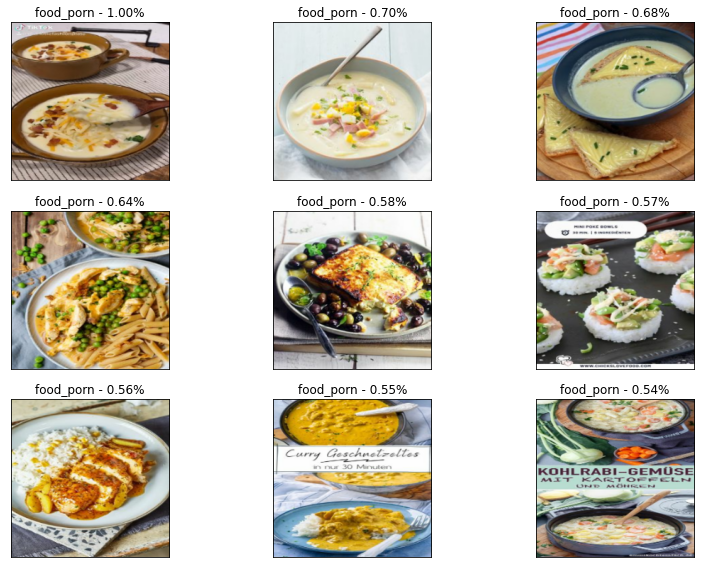

In [139]:
visualise_nearest_neighbours(691)